In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
import joblib
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Step 1: Problem Definition

In [2]:

"""
Objective: Predict customer churn for a telecom company.
Business Problem: Retain customers by identifying those likely to churn and taking proactive measures.
"""

'\nObjective: Predict customer churn for a telecom company.\nBusiness Problem: Retain customers by identifying those likely to churn and taking proactive measures.\n'

# Step 2: Data Collection
# Load the dataset

In [3]:

url = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)

In [4]:
# Display the first 5 rows of the dataset
print("Initial Dataset:")
print(df.head())

Initial Dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies    

# Step 3: Data Cleaning & Preprocessing

In [5]:

# Drop unnecessary columns
df.drop(columns=['customerID'], inplace=True)

# Convert 'TotalCharges' to numeric, handling errors
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values in 'TotalCharges' with the median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Convert 'Yes'/'No' to 1/0
yes_no_columns = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn']
for col in yes_no_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Convert categorical columns to 'category' type
categorical_columns = ['gender', 'InternetService', 'Contract', 'PaymentMethod']
df[categorical_columns] = df[categorical_columns].astype('category')


In [6]:
print(df.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


# Step 4: Feature Engineering

In [7]:
# Create 'TotalServices' feature
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServices'] = df[services].apply(lambda row: (row == 'Yes').sum(), axis=1)

# Create 'AverageMonthlySpend' feature
df['AverageMonthlySpend'] = df['TotalCharges'] / df['tenure'].replace(0, 1)  # Avoid division by zero

# Drop original service columns
df.drop(columns=services, inplace=True)


# Step 5: Exploratory Data Analysis (EDA)

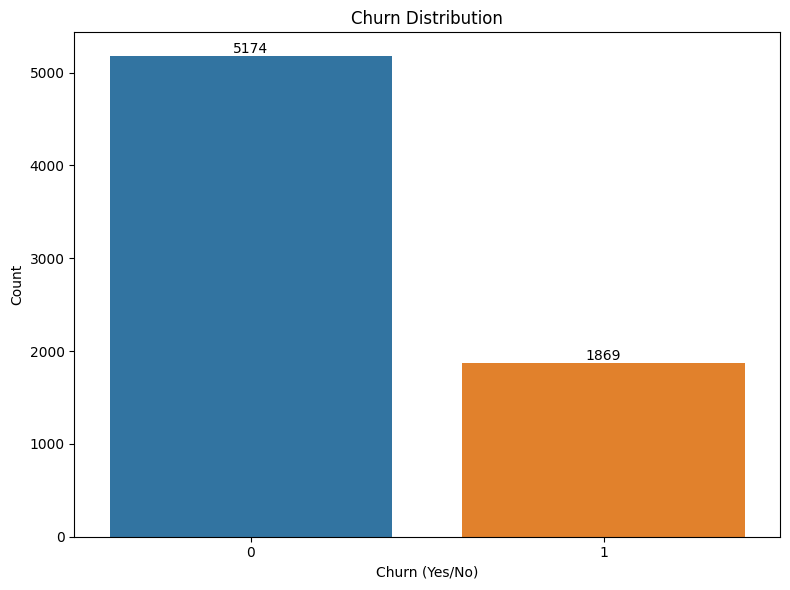

In [8]:
# Plot 1: Churn Distribution
plt.figure(figsize=(8, 6))
ax1 = sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (Yes/No)')
plt.ylabel('Count')

# Add total counts on top of the bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.show()


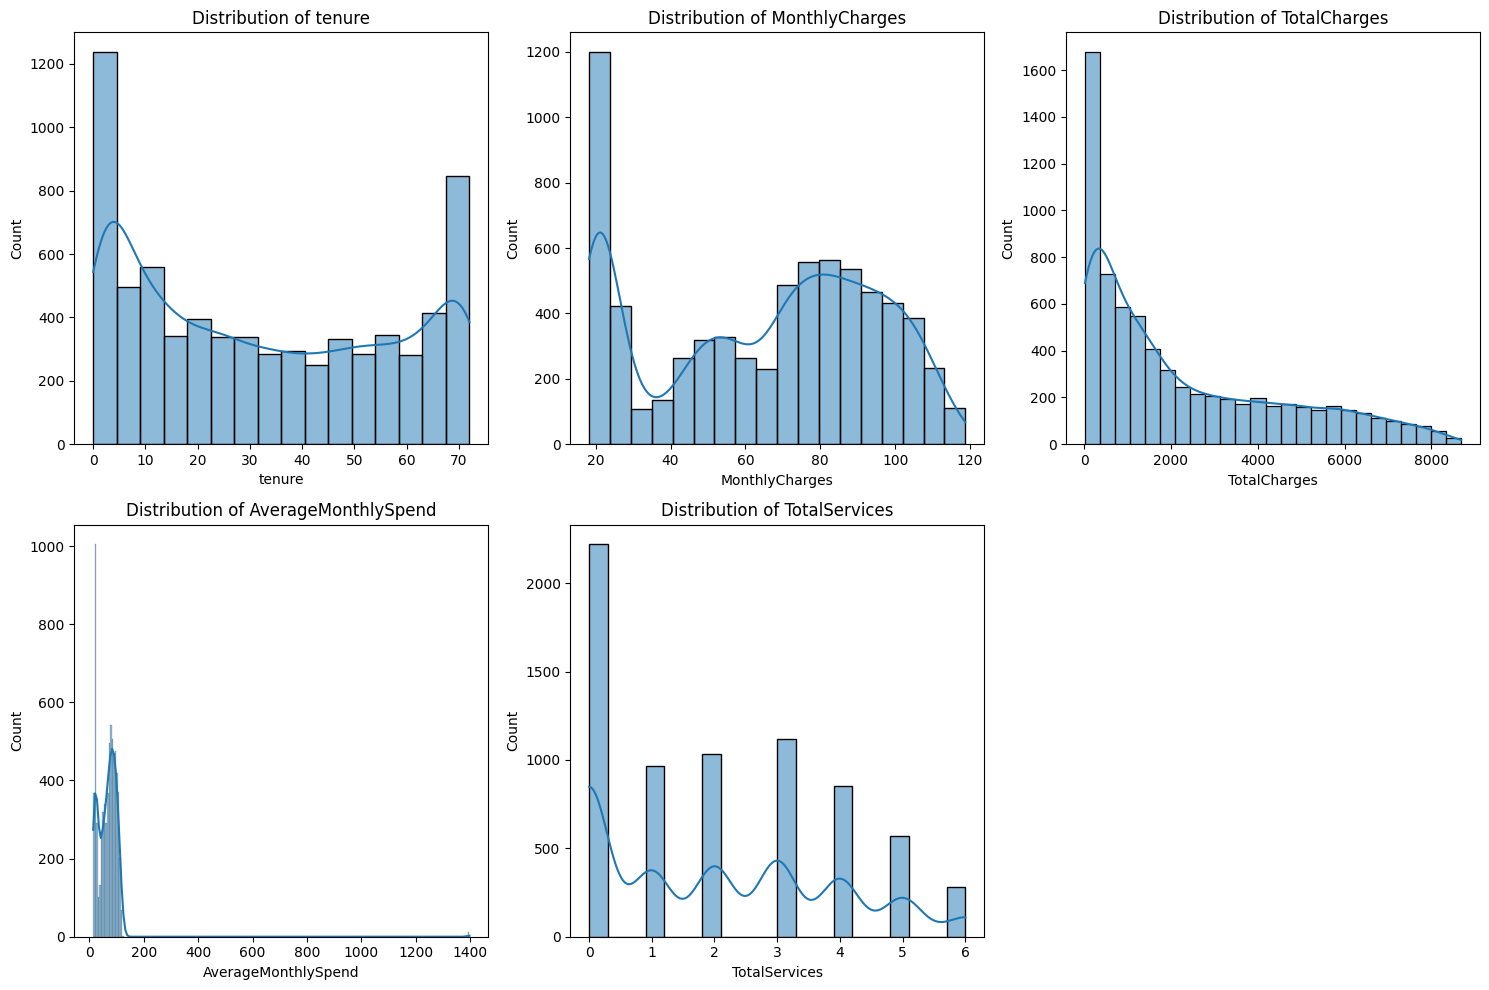

In [9]:
# Plot 2: Distribution of Numerical Features
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AverageMonthlySpend', 'TotalServices']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

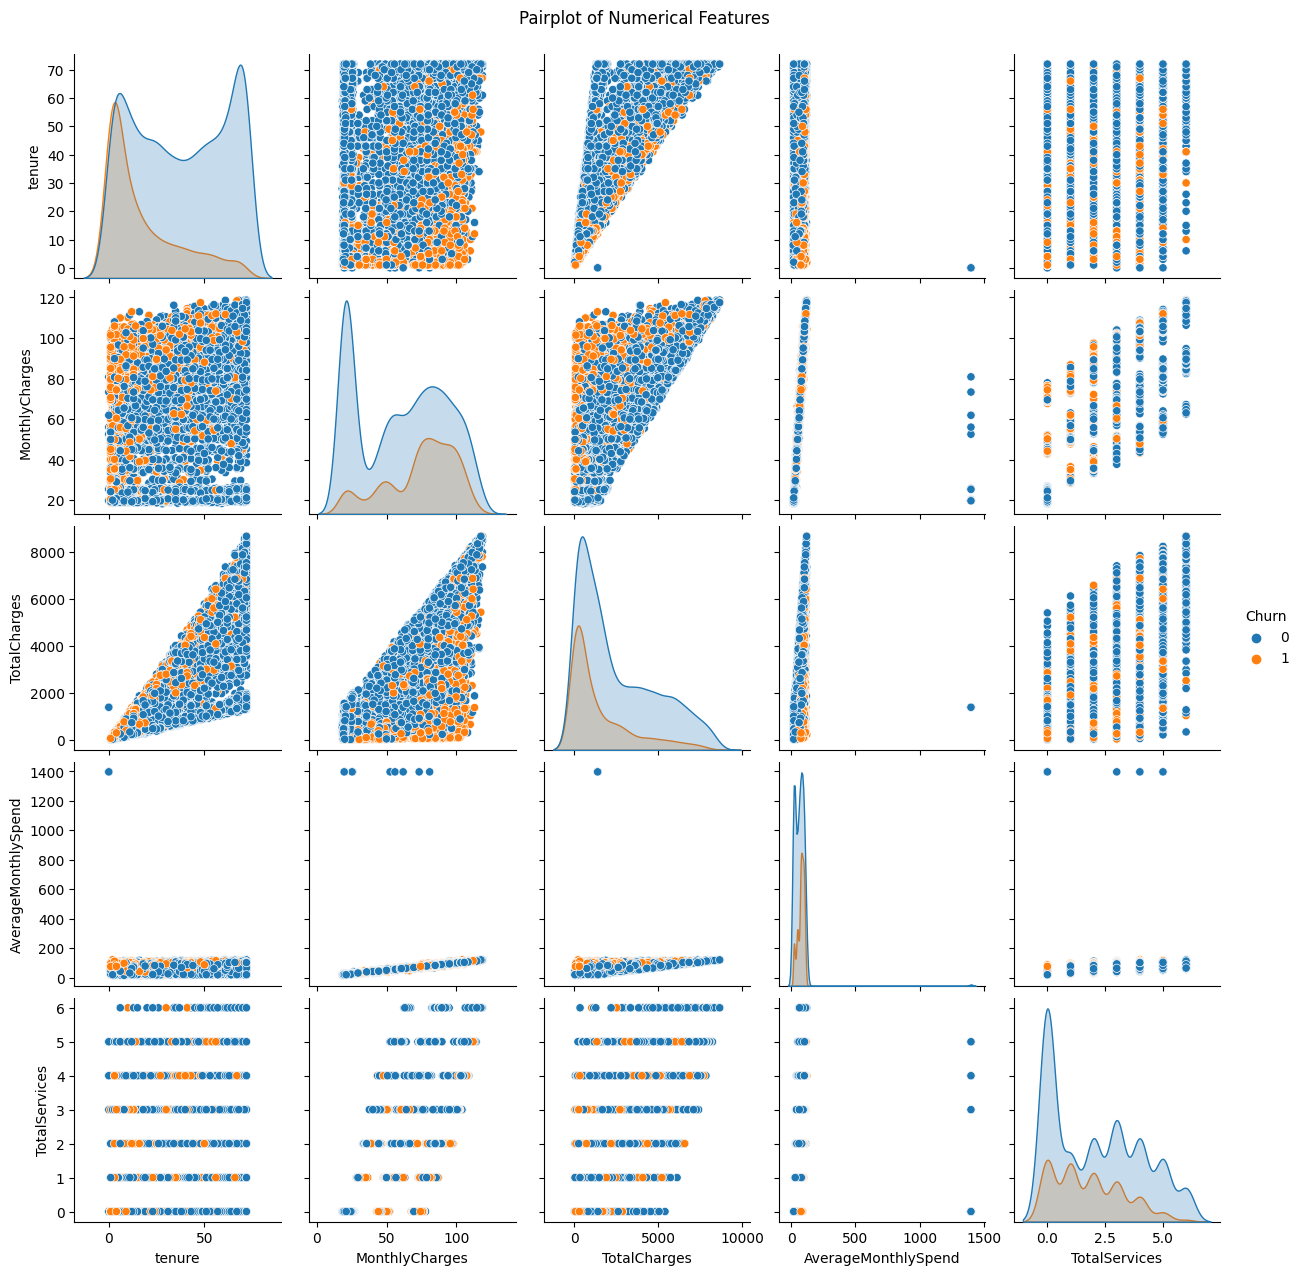

In [10]:
# Plot 3: Pairplot for Feature Relationships
sns.pairplot(df[numerical_columns + ['Churn']], hue='Churn', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()


# # Step 6: Data Splitting

In [11]:
# Split the data into features (X) and target (y)
X = df.drop(columns=['Churn'])  # Features
y = df['Churn']  # Target

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Step 7: Feature Scaling

In [12]:
# Scale all features (not just numerical columns)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 8: Model Selection

In [13]:
# Initialize models
log_reg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Step 9: Model Training & Evaluation

In [14]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return model

In [15]:
# Evaluate Logistic Regression
print("Logistic Regression Evaluation:")
log_reg_model = evaluate_model(log_reg, X_train, X_test, y_train, y_test, "Logistic Regression")


Logistic Regression Evaluation:
Model: Logistic Regression
Accuracy: 0.8111
Precision: 0.8104
Recall: 0.8189
F1-Score: 0.8146
ROC-AUC: 0.8110

Confusion Matrix:
[[820 201]
 [190 859]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1021
           1       0.81      0.82      0.81      1049

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070



In [16]:
# Evaluate Random Forest
print("Random Forest Evaluation:")
rf_model = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")


Random Forest Evaluation:
Model: Random Forest
Accuracy: 0.8406
Precision: 0.8434
Recall: 0.8418
F1-Score: 0.8426
ROC-AUC: 0.8406

Confusion Matrix:
[[857 164]
 [166 883]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1021
           1       0.84      0.84      0.84      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



In [17]:
# Evaluate XGBoost
print("XGBoost Evaluation:")
xgb_model = evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost")


XGBoost Evaluation:
Model: XGBoost
Accuracy: 0.8333
Precision: 0.8302
Recall: 0.8437
F1-Score: 0.8369
ROC-AUC: 0.8332

Confusion Matrix:
[[840 181]
 [164 885]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1021
           1       0.83      0.84      0.84      1049

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



# Step 10: Hyperparameter Tuning

In [18]:
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy')

In [19]:
# Get the best parameters
best_params = random_search.best_params_
print("\nBest Parameters for Random Forest:", best_params)


Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}


In [20]:
# Evaluate the tuned Random Forest model
tuned_rf = RandomForestClassifier(**best_params, random_state=42)
print("\nTuned Random Forest Evaluation:")
tuned_rf_model = evaluate_model(tuned_rf, X_train, X_test, y_train, y_test, "Tuned Random Forest")


Tuned Random Forest Evaluation:
Model: Tuned Random Forest
Accuracy: 0.8415
Precision: 0.8417
Recall: 0.8465
F1-Score: 0.8441
ROC-AUC: 0.8415

Confusion Matrix:
[[854 167]
 [161 888]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1021
           1       0.84      0.85      0.84      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



In [21]:

# Hyperparameter tuning for XGBoost
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_dist, n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)
xgb_random_search.fit(X_train, y_train)

# Get the best parameters
best_xgb_params = xgb_random_search.best_params_
print("\nBest Parameters for XGBoost:", best_xgb_params)


Best Parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


In [22]:

# Evaluate the tuned XGBoost model
tuned_xgb = XGBClassifier(**best_xgb_params, random_state=42)
print("\nTuned XGBoost Evaluation:")
tuned_xgb_model = evaluate_model(tuned_xgb, X_train, X_test, y_train, y_test, "Tuned XGBoost")


Tuned XGBoost Evaluation:
Model: Tuned XGBoost
Accuracy: 0.8295
Precision: 0.8295
Recall: 0.8351
F1-Score: 0.8323
ROC-AUC: 0.8294

Confusion Matrix:
[[841 180]
 [173 876]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1021
           1       0.83      0.84      0.83      1049

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



# Step 11: Ensemble Model (VotingClassifier)

In [23]:
# Combine Logistic Regression, Random Forest, and XGBoost
ensemble_model = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', tuned_rf), ('xgb', tuned_xgb)],
    voting='soft'  # Use 'soft' for probability-based voting
)

# Evaluate the Ensemble Model
print("\nEnsemble Model Evaluation:")
ensemble_model = evaluate_model(ensemble_model, X_train, X_test, y_train, y_test, "Ensemble Model")


Ensemble Model Evaluation:
Model: Ensemble Model
Accuracy: 0.8430
Precision: 0.8396
Recall: 0.8532
F1-Score: 0.8463
ROC-AUC: 0.8429

Confusion Matrix:
[[850 171]
 [154 895]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1021
           1       0.84      0.85      0.85      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



# Step 12: Cross-Validation for Robust Evaluation

In [24]:
# Cross-validation for the ensemble model
ensemble_scores = cross_val_score(ensemble_model, X_res, y_res, cv=5, scoring='accuracy')
print(f"\nEnsemble Model Cross-Validation Accuracy: {ensemble_scores.mean():.4f}")


Ensemble Model Cross-Validation Accuracy: 0.8357


# Step 13: Feature Importance

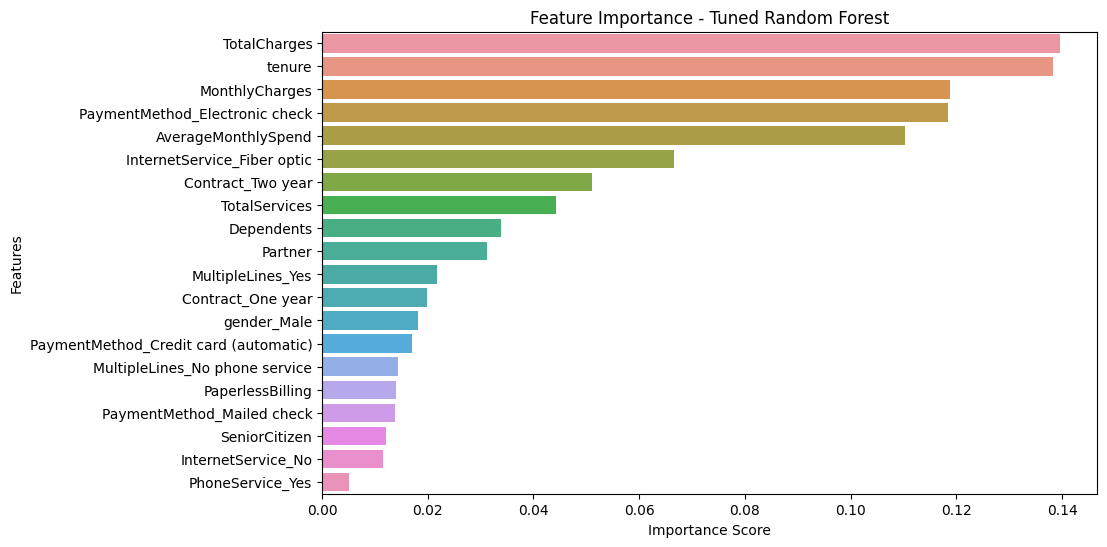

In [25]:
def plot_feature_importance(model, feature_names, model_name):
    feature_importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=feature_importance.index)
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

# Plot feature importance for Random Forest
plot_feature_importance(tuned_rf_model, X_encoded.columns, "Tuned Random Forest")

# Step 14: ROC Curve

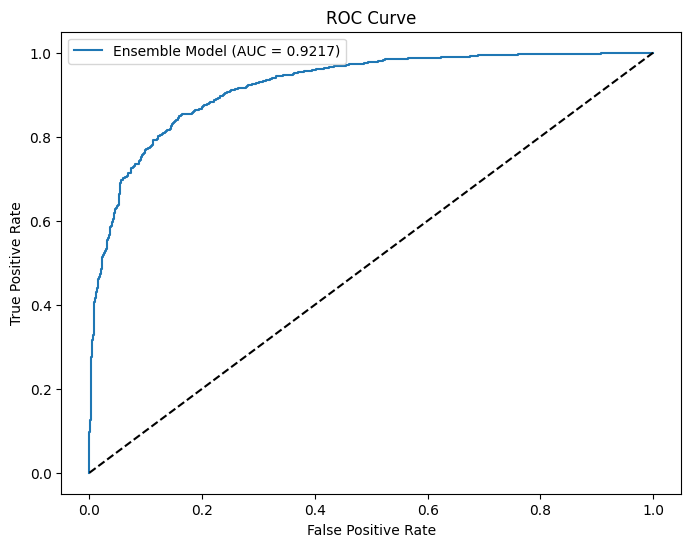

In [26]:
def plot_roc_curve(model, X_test, y_test, model_name):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Plot ROC Curve for the best model (Ensemble Model)
plot_roc_curve(ensemble_model, X_test, y_test, "Ensemble Model")

# Step 15: Model Deployment

In [27]:
# Save the best model to a file
model_filename = "best_churn_model.pkl"
joblib.dump(ensemble_model, model_filename)
print(f"\nModel saved to {model_filename}")


Model saved to best_churn_model.pkl
